In [2]:
import os

In [3]:
import zipfile

In [4]:
os.listdir('./train')

['1gr', '2gr', '3gr']

In [5]:
import matplotlib.pyplot as plt
import PIL
import tensorflow as tf
import numpy as np
import os

In [6]:
from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Dropout, Activation, GlobalAveragePooling2D
from keras.applications.resnet50 import ResNet50
from keras.applications.vgg16 import preprocess_input, decode_predictions, VGG16
from keras.applications.densenet import DenseNet121
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, RMSprop
from keras import backend as K
from keras.models import load_model
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [7]:
from sklearn.decomposition import PCA
from sklearn import svm
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.grid_search import GridSearchCV
from sklearn.utils.class_weight import compute_class_weight

c:\users\paperspace\anaconda3\envs\tensorflow-gpu\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
c:\users\paperspace\anaconda3\envs\tensorflow-gpu\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [8]:
model = VGG16(include_top=False, weights='imagenet', input_shape=(224,224,3))

In [9]:
input_shape=model.layers[0].output_shape[1:3]
input_shape

(224, 224)

In [10]:
datagen_train = ImageDataGenerator(
      rescale=1./128)

In [11]:
datagen_test = ImageDataGenerator(rescale=1./128)

In [18]:
epochs=2
batch_size = 100
steps_per_epoch_train=22500//100
steps_per_epoch_val=7500//10


In [13]:
generator_train.reset()
generator_train = datagen_train.flow_from_directory(directory='./train',
                               
                                                    target_size=(224,224),
                                                    batch_size=100,
                                                    class_mode='categorical',shuffle=False)

Found 22500 images belonging to 3 classes.


In [16]:
generator_test.reset()
generator_test = datagen_test.flow_from_directory(directory='./val',
                                                  target_size=(224,224),
                                                  batch_size=100,
                                                  class_mode='categorical',
                                                  shuffle=False)

Found 7500 images belonging to 3 classes.


In [19]:
steps_test = generator_test.n / batch_size
steps_test

75.0

In [20]:
from sklearn.utils.class_weight import compute_class_weight

In [21]:
cls_train = generator_train.classes


In [22]:
cls_test = generator_test.classes

In [23]:
class_weight = compute_class_weight(class_weight='balanced', classes=np.unique(cls_train), y=cls_train)

In [24]:
class_weight

array([ 1.,  1.,  1.])

In [25]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [26]:
transfer_layer = model.get_layer('block5_pool')

In [27]:
transfer_layer.output

<tf.Tensor 'block5_pool/MaxPool:0' shape=(?, 7, 7, 512) dtype=float32>

In [28]:
conv_model = Model(inputs=model.input, outputs=transfer_layer.output)

In [29]:
model.input

<tf.Tensor 'input_1:0' shape=(?, 224, 224, 3) dtype=float32>

In [30]:
new_model = Sequential()
new_model.add(conv_model)
new_model.add(Flatten())
new_model.add(Dense(256, activation='relu'))
new_model.add(Dropout(0.5))
new_model.add(Dense(3, activation='softmax'))

In [31]:
def print_layer_trainable():
  for layer in conv_model.layers:
    print("{0}: {1}".format(layer.trainable, layer.name))

In [32]:
for layer in conv_model.layers:
  layer.trainable = False

In [33]:
loss='categorical_crossentropy'
metrics=['categorical_accuracy']


In [34]:
len(conv_model.layers)

19

In [35]:
for layer in conv_model.layers[:]:
 
  layer.trainable=False

In [36]:
print_layer_trainable()

False: input_1
False: block1_conv1
False: block1_conv2
False: block1_pool
False: block2_conv1
False: block2_conv2
False: block2_pool
False: block3_conv1
False: block3_conv2
False: block3_conv3
False: block3_pool
False: block4_conv1
False: block4_conv2
False: block4_conv3
False: block4_pool
False: block5_conv1
False: block5_conv2
False: block5_conv3
False: block5_pool


In [37]:
optimizer_fine = Adam(lr=1e-5)
new_model.compile(optimizer=optimizer_fine, loss=loss, metrics=metrics)

In [39]:
earlystopping = EarlyStopping(monitor='val_loss', patience=10)

In [ ]:
history1 = new_model.fit_generator(generator=generator_train,
                                  epochs=100,
                                  steps_per_epoch=steps_per_epoch_train,
                                  class_weight=class_weight,
                                  validation_data=generator_test,
                                  validation_steps=steps_per_epoch_val,
                                  callbacks=[earlystopping])


Epoch 1/100
225/225 [==============================] - 699s 3s/step - loss: 1.1317 - categorical_accuracy: 0.4331 - val_loss: 0.8899 - val_categorical_accuracy: 0.6176
Epoch 2/100
225/225 [==============================] - 583s 3s/step - loss: 0.8680 - categorical_accuracy: 0.5925 - val_loss: 0.7146 - val_categorical_accuracy: 0.7283
Epoch 3/100
225/225 [==============================] - 582s 3s/step - loss: 0.7457 - categorical_accuracy: 0.6803 - val_loss: 0.6198 - val_categorical_accuracy: 0.7869
Epoch 4/100
225/225 [==============================] - 582s 3s/step - loss: 0.6429 - categorical_accuracy: 0.7471 - val_loss: 0.5524 - val_categorical_accuracy: 0.8677
Epoch 5/100
225/225 [==============================] - 584s 3s/step - loss: 0.5758 - categorical_accuracy: 0.7829 - val_loss: 0.5615 - val_categorical_accuracy: 0.7499
Epoch 6/100
225/225 [==============================] - 584s 3s/step - loss: 0.5485 - categorical_accuracy: 0.7907 - val_loss: 0.4934 - val_categorical_accuracy:

225/225 [==============================] - 484s 2s/step - loss: 0.1166 - categorical_accuracy: 0.9669 - val_loss: 0.1165 - val_categorical_accuracy: 0.9639
Epoch 50/100
224/225 [============================>.] - ETA: 0s - loss: 0.1105 - categorical_accuracy: 0.9706

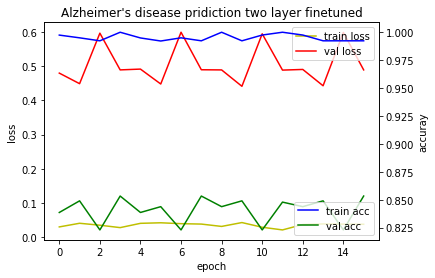

In [0]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(history1.history['loss'], 'y', label='train loss')
loss_ax.plot(history1.history['val_loss'], 'r', label='val loss')

acc_ax.plot(history1.history['categorical_accuracy'], 'b', label='train acc')
acc_ax.plot(history1.history['val_categorical_accuracy'], 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper right')
acc_ax.legend(loc='lower right')
plt.title("Alzheimer's disease pridiction two layer finetuned")

plt.show()

In [ ]:
model.save('../0629_vgg16_withaug.h5')

In [0]:
class_name = generator_train.class_indices.keys()

In [0]:
train_dir = '../train1'
test_dir = '../valid1'


In [0]:
def path_join(dirname, filenames):
    return [os.path.join(dirname, filename) for filename in filenames]

In [0]:
len(generator_train.filenames)
len(generator_test.filenames)

152

In [0]:

image_paths_train = path_join(train_dir, generator_train.filenames)
image_paths_test = path_join(test_dir, generator_test.filenames)

In [0]:

cls_train = generator_train.classes
cls_test = generator_test.classes

In [0]:
class_names = list(generator_train.class_indices.keys())
class_names

['1gr', '3gr', '2gr']

In [0]:
def plot_images(images, cls_true, cls_pred=None, smooth=True):

    assert len(images) == len(cls_true)

    # Create figure with sub-plots.
    fig, axes = plt.subplots(3, 3)

    # Adjust vertical spacing.
    if cls_pred is None:
        hspace = 0.3
    else:
        hspace = 0.6
    fig.subplots_adjust(hspace=hspace, wspace=0.3)

    # Interpolation type.
    if smooth:
        interpolation = 'spline16'
    else:
        interpolation = 'nearest'

    for i, ax in enumerate(axes.flat):
        # There may be less than 9 images, ensure it doesn't crash.
        if i < len(images):
            # Plot image.
            ax.imshow(images[i],
                      interpolation=interpolation)

            # Name of the true class.
            cls_true_name = class_names[cls_true[i]]

            # Show true and predicted classes.
            if cls_pred is None:
                xlabel = "True: {0}".format(cls_true_name)
            else:
                # Name of the predicted class.
                cls_pred_name = class_names[cls_pred[i]]

                xlabel = "True: {0}\nPred: {1}".format(cls_true_name, cls_pred_name)

            # Show the classes as the label on the x-axis.
            ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [0]:
# Import a function from sklearn to calculate the confusion-matrix.
from sklearn.metrics import confusion_matrix

def print_confusion_matrix(cls_pred):
    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_test,  # True class for test-set.
                          y_pred=cls_pred)  # Predicted class.
    re = classification_report(y_true=cls_test,
                               y_pred=cls_pred)
    print("Confusion matrix:")
    
    # Print the confusion matrix as text.
    print(cm)
    print(re)
    
    # Print the class-names for easy reference.
    for i, class_name in enumerate(class_names):
        print("({0}) {1}".format(i, class_name))

In [0]:
def plot_example_errors(cls_pred):
    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Boolean array whether the predicted class is incorrect.
    incorrect = (cls_pred != cls_test)

    # Get the file-paths for images that were incorrectly classified.
    image_paths = np.array(image_paths_test)[incorrect]

    # Load the first 9 images.
    images = load_images(image_paths=image_paths[0:9])
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = cls_test[incorrect]
    
    # Plot the 9 images we have loaded and their corresponding classes.
    # We have only loaded 9 images so there is no need to slice those again.
    plot_images(images=images,
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

In [0]:
def example_errors():
    # The Keras data-generator for the test-set must be reset
    # before processing. This is because the generator will loop
    # infinitely and keep an internal index into the dataset.
    # So it might start in the middle of the test-set if we do
    # not reset it first. This makes it impossible to match the
    # predicted classes with the input images.
    # If we reset the generator, then it always starts at the
    # beginning so we know exactly which input-images were used.
    generator_test.reset()
    
    # Predict the classes for all images in the test-set.
    y_pred = new_model.predict_generator(generator_test,
                                         steps=steps_test)

    # Convert the predicted classes from arrays to integers.
    cls_pred = np.argmax(y_pred,axis=1)

    # Plot examples of mis-classified images.
    plot_example_errors(cls_pred)
    
    # Print the confusion matrix.
    print_confusion_matrix(cls_pred)

In [0]:
def load_images(image_paths):
    # Load the images from disk.
    images = [plt.imread(path) for path in image_paths]

    # Convert to a numpy array and return it.
    return np.asarray(images)

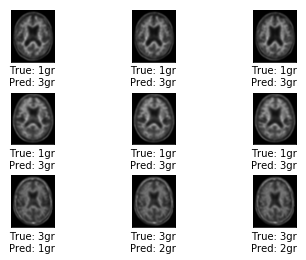

Confusion matrix:
[[67  6  0]
 [10  5  5]
 [ 0  3 56]]
             precision    recall  f1-score   support

          0       0.87      0.92      0.89        73
          1       0.36      0.25      0.29        20
          2       0.92      0.95      0.93        59

avg / total       0.82      0.84      0.83       152

(0) 1gr
(1) 3gr
(2) 2gr


In [0]:
example_errors()